## Load libraries

In [233]:
# Libraries to work cross-platform
import os

# Libraries to work with dataset
import numpy as np
import pandas as pd
import ast                      # convert string to list after importing csv data
import pickle

# Libraries to cluster data
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

# Libraries to visualize data
import matplotlib.pyplot as plt
import seaborn as sns
# import matplotlib.cm as cm
from cluster_visualization_helper import (
    compute_cluster_visualization,
    visualize_cluster)  # user-defined functions
from pprint import pprint

# Libraries for evaluation
from gensim.models import CoherenceModel
from gensim.models.callbacks import PerplexityMetric, ConvergenceMetric, CoherenceMetric

# Libraries for monitoring operation process
from datetime import datetime
from tqdm import tqdm
import logging
# import re

## Configurate and declare global variables

In [146]:
os_name = os.name

if os_name == 'nt':  
    """Windows platform"""
    BASE_DIR = "E:/THIENDHB_GOOGLEDRIVE/MASTER TILBURG/THESIS/"
    INPUT_DIR = BASE_DIR + "DATASET/INPUT/"
    OUTPUT_DIR = BASE_DIR + "DATASET/OUTPUT/"
elif os_name == 'posix':
    """Linux platform"""
    BASE_DIR = "/media/pinkalinux/WORK/THIENDHB_GOOGLEDRIVE/MASTER TILBURG/THESIS/"
    INPUT_DIR = BASE_DIR + "DATASET/INPUT/"
    OUTPUT_DIR = BASE_DIR + "DATASET/OUTPUT/"

SEED = 6886
%matplotlib inline

## Import data

In [147]:
skill_docs = pd.read_csv(
    OUTPUT_DIR + "skill_tokens_long_df.csv",
    converters={
        "skill_description_tokens": ast.literal_eval,
        "skill_requirement_tokens": ast.literal_eval,
        "skill_qualification_tokens": ast.literal_eval
    },
    dtype={
        "skill_id": int,
        "job_id": int,
        "job_description": str,
        "job_requirement": str,
        "job_qualification": str
    }
)
skill_docs.shape

Exception ignored in: <function tqdm.__del__ at 0x0000020B8C93F1F0>
Traceback (most recent call last):
  File "c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\tqdm\std.py", line 1143, in __del__
    self.close()
  File "c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\tqdm\std.py", line 1272, in close
    if self.last_print_t < self.start_t + self.delay:
AttributeError: 'tqdm' object has no attribute 'last_print_t'


(361584, 8)

In [148]:
# Create text and token columns
skill_docs["feature_skills_tokens"] = (
    skill_docs["skill_description_tokens"] + skill_docs["skill_requirement_tokens"]
)

skill_docs["feature_skills"] = (
    skill_docs["job_description"] + " " + skill_docs["job_requirement"]
)

In [149]:
skill_docs.iloc[:10, ]

,skill_id,job_id,job_description,skill_description_tokens,job_requirement,skill_requirement_tokens,job_qualification,skill_qualification_tokens,feature_skills_tokens,feature_skills
0,1,1,ameria investment consulting company,"[ameria, investment, consulting, company]",liquidity reserves assists investment team,"[liquidity, reserves, assists, investment, team]",providing job performance feedback,"[providing, job, performance, feedback]","[ameria, investment, consulting, company, liqu...",ameria investment consulting company liquidity...
1,2,1,provides highly responsible,"[provides, highly, responsible]",incorporation regarding corporate registration,"[incorporation, regarding, corporate, registra...",operate specialized software applications,"[operate, specialized, software, applications]","[provides, highly, responsible, incorporation,...",provides highly responsible incorporation rega...
2,3,1,complex staff assistance,"[complex, staff, assistance]",including evaluating loss exposure,"[including, evaluating, loss, exposure]",state reporting requirements pertaining,"[state, reporting, requirements, pertaining]","[complex, staff, assistance, including, evalua...",complex staff assistance including evaluating ...
3,4,1,chief financial officer,"[chief, financial, officer]",internal financial management reports,"[internal, financial, management, reports]",generally accepted accounting principles,"[generally, accepted, accounting, principles]","[chief, financial, officer, internal, financia...",chief financial officer internal financial man...
4,5,1,investment management,"[investment, management]",investment team leader,"[investment, team, leader]",accounting technical skills coupled,"[accounting, technical, skills, coupled]","[investment, management, investment, team, lea...",investment management investment team leader
5,6,1,financial management,"[financial, management]",management team participating,"[management, team, participating]",database software applications,"[database, software, applications]","[financial, management, management, team, part...",financial management management team participa...
6,7,1,work performed,"[work, performed]",recommending disciplinary action,"[recommending, disciplinary, action]",supervisory track record,"[supervisory, track, record]","[work, performed, recommending, disciplinary, ...",work performed recommending disciplinary action
7,8,1,technical proficiency,"[technical, proficiency]",giving performance evaluations,"[giving, performance, evaluations]",essential duty satisfactorily,"[essential, duty, satisfactorily]","[technical, proficiency, giving, performance, ...",technical proficiency giving performance evalu...
8,9,1,position manages,"[position, manages]",audited financial statements,"[audited, financial, statements]",critically analyze fiscal,"[critically, analyze, fiscal]","[position, manages, audited, financial, statem...",position manages audited financial statements
9,10,1,high level,"[high, level]",annual budgeting process,"[annual, budgeting, process]",compatible personal computer,"[compatible, personal, computer]","[high, level, annual, budgeting, process]",high level annual budgeting process


Text(0.5, 1.0, 'Distribution of word count in the job skills')

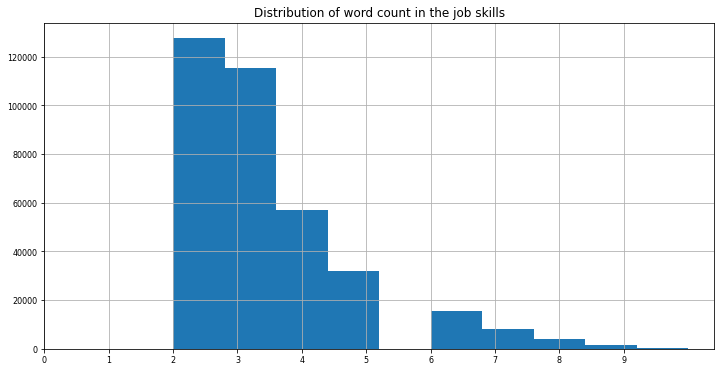

In [150]:
skill_docs["word_count"] = skill_docs["feature_skills_tokens"].apply(lambda x: len(x))
skill_docs[["word_count"]].hist(figsize=(12, 6), bins=10, xlabelsize=8, ylabelsize=8)
plt.xticks(list(range(max(skill_docs["word_count"].values))))
plt.title("Distribution of word count in the job skills")

## Clustering data

### LDA

In [151]:
# Create doc list of clean job skills
doc_list = skill_docs["feature_skills"].values.tolist()
pprint(doc_list[:10])

# Create corpus (list of tokens per document)
skill_corpus = skill_docs["feature_skills_tokens"].values.tolist()
pprint(skill_corpus[:10])

# Create Dictionary
id2word = Dictionary(skill_corpus)

# Term Document Frequency
lda_corpus = [id2word.doc2bow(text) for text in skill_corpus]
pprint(lda_corpus[:3])

['ameria investment consulting company liquidity reserves assists investment '
 'team',
 'provides highly responsible incorporation regarding corporate registration',
 'complex staff assistance including evaluating loss exposure',
 'chief financial officer internal financial management reports',
 'investment management investment team leader',
 'financial management management team participating',
 'work performed recommending disciplinary action',
 'technical proficiency giving performance evaluations',
 'position manages audited financial statements',
 'high level annual budgeting process']
[['ameria',
  'investment',
  'consulting',
  'company',
  'liquidity',
  'reserves',
  'assists',
  'investment',
  'team'],
 ['provides',
  'highly',
  'responsible',
  'incorporation',
  'regarding',
  'corporate',
  'registration'],
 ['complex',
  'staff',
  'assistance',
  'including',
  'evaluating',
  'loss',
  'exposure'],
 ['chief',
  'financial',
  'officer',
  'internal',
  'financial',

In [157]:
def build_lda_model(dictionary, corpus, texts, k, a, b, seed):
    """
    Build LDA Topic model

    Parameters:
    ----------
    dictionary: Gensim dictionary
    corpus: Gensim corpus
    texts: list of input texts
    k: number of topics
    a: Dirichlet hyperparameter alpha (Document-Topic Density)
    b: Dirichlet hyperparameter beta (Word-Topic Density)

    Returns:
    -------
    model: LDA topic models
    """

#     # Set up logger for callback
#     logging.basicConfig(
#         filename=OUTPUT_DIR + "skills_lda_model_callbacks.log",
#         format="%(asctime)s:%(levelname)s:%(message)s",
#         level=logging.NOTSET,
#     )

#     perplexity_logger = PerplexityMetric(corpus=corpus, logger="shell")
#     convergence_logger = ConvergenceMetric(logger="shell")
#     coherence_cv_logger = CoherenceMetric(
#         corpus=corpus, logger="shell", coherence="c_v", texts=texts
#     )

#     logging.debug("Start of LDA model for skillsets")

    model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=k,
        random_state=seed,
        update_every=0,
        chunksize=10000,
        passes=10,
        alpha=a,
        eta=b,
        iterations=100,
#         callbacks=[convergence_logger, perplexity_logger, coherence_cv_logger],
    )

#     logging.debug("End of LDA model for skillsets")
    model.save(
        OUTPUT_DIR
        + "skill_lda_"
        + str(k)
        + "-topics_alpha-"
        + str(a)
        + "_beta-"
        + str(b)
        + ".model"
    )

    return model

In [158]:
def compute_evaluation_metrics(model, corpus, dictionary, texts):
    """
    Compute c_v coherence and perplexity for various number of topics

    Parameters:
    ----------
    model: LDA topic model
    corpus: Gensim corpus
    dictionary: Gensim dictionary
    texts: List of input texts

    Returns:
    -------
    coherence_value: Coherence value corresponding to the LDA model
    perplexity_value: Perplexity value corresponding to the LDA model

    Coherence is a measure of similarity between top scoring words in topics.
    The version used here is c_v coherence.
    Scores are between 0 and 1. Closer to 1 is better.

    Perplexity is a statistical measure
    giving the normalised log-likelihood of a test set
    held out from the training data.
    The probability of the unseen data occurring
    given the data the model was trained on.
    The higher the figure, the more ‘surprising’ the new data is,
    so a low score suggests a model that adapts better to unseen data.
    Perplexity and human judgment are often not correlated.
    Depending on what we want, this might not be the best metric.
    """

    coherencemodel = CoherenceModel(
        model=model, texts=texts, dictionary=dictionary, coherence="c_v"
    )

    perplexity_value = model.log_perplexity(corpus)
    coherence_value = coherencemodel.get_coherence()

    return coherence_value, perplexity_value

In [159]:
# Preparing hyperparameters for tuning
grid = {}

# Topics range
topics_range = [5, 10, 15, 20, 25, 50, 75, 100]

# Alpha parameter
# alpha = list(np.arange(0.01, 2, 0.5))
# alpha.append("symmetric")
# alpha.append("asymmetric")
alpha_list = ['auto']
# alpha = [0.01, 0.1, 0.25, 0.5, 0.75]

# Beta parameter
# beta = list(np.arange(0.01, 2, 0.5))
# beta.append("symmetric")
# beta = [0.01]
beta_list = ['auto']

# Initialize
model_list = []
duration_list = []
model_results = {
    "Topics": [],
    "Alpha": [],
    "Beta": [],
    "Coherence": [],
    "Perplexity": []
}

In [160]:
len(topics_range) * len(alpha_list) * len(beta_list)

8

In [162]:
# Tuning LDA to find optimal number of topics
start_loop_time = datetime.now()
print("Start loop", start_loop_time.strftime("%Y-%m-%d %H:%M:%S.%f"))

pbar = tqdm(
    desc="LDA tuning",
    total=len(topics_range) * len(alpha_list) * len(beta_list),
)

# iterate through number of topics
for k in topics_range:

    starttime = datetime.now()
    print("Start", starttime.strftime("%Y-%m-%d %H:%M:%S.%f"))

    # iterate through alpha values
    for a in alpha_list:
        # iterare through beta values
        for b in beta_list:
            # get the coherence score and perplexity for the given parameters
            lda_model = build_lda_model(
                dictionary=id2word,
                corpus=lda_corpus,
                texts=skill_corpus,
                k=k,
                a=a,
                b=b,
                seed=SEED,
            )
            cv_score, perplexity = compute_evaluation_metrics(
                lda_model,
                corpus=lda_corpus,
                dictionary=id2word,
                texts=skill_corpus,
            )

            # Save the model results
            model_results["Topics"].append(k)
            model_results["Alpha"].append(a)
            model_results["Beta"].append(b)
            model_results["Coherence"].append(cv_score)
            model_results["Perplexity"].append(perplexity)

            endtime = datetime.now()
            print("End", endtime.strftime("%Y-%m-%d %H:%M:%S.%f"))
            print("Duration", endtime - starttime)

            model_list.append(lda_model)
            duration_list.append(round((endtime - starttime).seconds / 60, 2))

            pbar.update(1)
pbar.close()

end_loop_time = datetime.now()
print("End loop", end_loop_time.strftime("%Y-%m-%d %H:%M:%S.%f"))
print("Duration", end_loop_time - start_loop_time)

LDA tuning:   0%|                                                                                | 0/8 [00:00<?, ?it/s]

Start loop 2021-05-03 19:16:56.930306
Start 2021-05-03 19:16:56.933307


LDA tuning:  12%|████████▌                                                           | 1/8 [19:10<2:14:10, 1150.07s/it]

End 2021-05-03 19:36:07.000765
Duration 0:19:10.067458
Start 2021-05-03 19:36:07.006764


LDA tuning:  25%|█████████████████                                                   | 2/8 [39:15<1:58:14, 1182.39s/it]

End 2021-05-03 19:56:12.018632
Duration 0:20:05.011868
Start 2021-05-03 19:56:12.029598


LDA tuning:  38%|████████████████████████▊                                         | 3/8 [1:00:24<1:41:50, 1222.04s/it]

End 2021-05-03 20:17:21.230919
Duration 0:21:09.201321
Start 2021-05-03 20:17:21.262164


LDA tuning:  50%|█████████████████████████████████                                 | 4/8 [1:22:25<1:24:04, 1261.12s/it]

End 2021-05-03 20:39:22.271527
Duration 0:22:01.009363
Start 2021-05-03 20:39:22.287153


LDA tuning:  62%|█████████████████████████████████████████▎                        | 5/8 [1:47:24<1:07:21, 1347.04s/it]

End 2021-05-03 21:04:21.645083
Duration 0:24:59.357930
Start 2021-05-03 21:04:21.738792


LDA tuning:  75%|███████████████████████████████████████████████████                 | 6/8 [2:22:23<53:25, 1602.66s/it]

End 2021-05-03 21:39:20.478030
Duration 0:34:58.739238
Start 2021-05-03 21:39:20.571787


LDA tuning:  88%|███████████████████████████████████████████████████████████▌        | 7/8 [3:03:51<31:31, 1891.95s/it]

End 2021-05-03 22:20:48.043558
Duration 0:41:27.471771
Start 2021-05-03 22:20:48.121656


LDA tuning: 100%|████████████████████████████████████████████████████████████████████| 8/8 [3:46:19<00:00, 1697.38s/it]

End 2021-05-03 23:03:15.847208
Duration 0:42:27.725552
End loop 2021-05-03 23:03:15.987828
Duration 3:46:19.057522


In [163]:
pprint(model_results)

{'Alpha': ['auto', 'auto', 'auto', 'auto', 'auto', 'auto', 'auto', 'auto'],
 'Beta': ['auto', 'auto', 'auto', 'auto', 'auto', 'auto', 'auto', 'auto'],
 'Coherence': [0.20728629564293483,
               0.2106707929428266,
               0.18248260272736977,
               0.19053764031775527,
               0.19838403479503974,
               0.3960543284944324,
               0.4525904730786196,
               0.47857656175911323],
 'Perplexity': [-6.404620235772239,
                -6.424697039870692,
                -6.44817396617916,
                -6.48573358051482,
                -6.513528939636765,
                -7.3378036578286725,
                -8.785173004102875,
                -14.840623615470953],
 'Topics': [5, 10, 15, 20, 25, 50, 75, 100]}


## Save model tuning results to file

In [164]:
# Save tuning results to file
# model_results_df = pd.DataFrame(model_results)
# model_results_df.to_csv(OUTPUT_DIR + "skills_lda_tuning_results.csv", index=False)

# Combine model sets
tuple_objects = (
    model_list,
    duration_list,
    model_results
)
len(tuple_objects), len(tuple_objects[0])

(3, 8)

In [165]:
pprint(tuple_objects)

([<gensim.models.ldamodel.LdaModel object at 0x0000020BB3A983D0>,
 [19.17, 20.08, 21.15, 22.02, 24.98, 34.97, 41.45, 42.45],
 {'Alpha': ['auto', 'auto', 'auto', 'auto', 'auto', 'auto', 'auto', 'auto'],
  'Beta': ['auto', 'auto', 'auto', 'auto', 'auto', 'auto', 'auto', 'auto'],
  'Coherence': [0.20728629564293483,
                0.2106707929428266,
                0.18248260272736977,
                0.19053764031775527,
                0.19838403479503974,
                0.3960543284944324,
                0.4525904730786196,
                0.47857656175911323],
  'Perplexity': [-6.404620235772239,
                 -6.424697039870692,
                 -6.44817396617916,
                 -6.48573358051482,
                 -6.513528939636765,
                 -7.3378036578286725,
                 -8.785173004102875,
                 -14.840623615470953],
  'Topics': [5, 10, 15, 20, 25, 50, 75, 100]})


In [166]:
# Save tuple
pickle.dump(tuple_objects, open(OUTPUT_DIR + "skills_lda_tuning2_results.pkl", "wb"))

In [167]:
# # Load pickle
# (
#     model_list,
#     duration_list,
#     model_results
# ) = pickle.load(open(OUTPUT_DIR + "skills_lda_tuning_results.pkl", "rb"))

## Evaluate cluster performance

In [190]:
# # Function to detect relevant numbers in log
# def find_doc_convergence(topic_num, log):
#     # Regex to bookend log for iteration - choose last occurrence
#     end_slice = re.compile("End of LDA model for skillsets")
#     end_matches = [end_slice.findall(i) for i in open(log)]
# #     print('end_matches =', end_matches)
#     iteration_end = [i for i, x in enumerate(end_matches) if x]
#     iteration_end = iteration_end[-1]
# #     print('iteration_end =', iteration_end)
#     start_slice = re.compile("Start of LDA model for skillsets")
#     start_matches = [start_slice.findall(i) for i in open(log)]
# #     print('start_matches =', start_matches)
#     start_options = [i for i, x in enumerate(start_matches) if x]
#     start_options = [item for item in start_options if item < iteration_end]
#     iteration_start = max(start_options)
# #     print('iteration_start =', iteration_start)
#     iteration_bookends = [iteration_start, iteration_end]
# #     print('iteration_bookends =', iteration_bookends)
#     # Regex to find documents converged figures
#     p = re.compile(":(\d+)\/\d")
#     matches = [p.findall(i) for i in open(log)]
# #     print('matches =', matches)
#     matches = matches[iteration_bookends[0]:iteration_bookends[1]]
# #     print('matches =', matches)
#     matches = [m for m in matches if len(m) > 0]
# #     print('matches =', matches)
#     # Unlist internal lists and turn into numbers
#     matches = [m for sublist in matches for m in sublist]
# #     print('matches =', matches)
#     matches = [float(m) for m in matches]
#     print('matches =', matches)
#     return(matches)

In [192]:
# all_metrics = pd.DataFrame()

# for idx in range(len(model_list)):
# #             model = LdaModel.load(
# #                 OUTPUT_DIR
# #                 + 
# #                 "skill_lda_"
# #                 + str(k)
# #                 + "-topics_alpha-"
# #                 + str(a)
# #                 + "_beta-"
# #                 + str(b)
# #                 + ".model"
# #             )
#     model = model_list[idx]
#     df = pd.DataFrame.from_dict(model.metrics)
# #     print(len(model.metrics), df.shape)
    
# #     df["docs_converged"] = 
#     tmp_list = find_doc_convergence(
# #         5, OUTPUT_DIR + "skills_lda_model_callbacks.log"
#         5, "skills_lda_model_callbacks.log"
#     )
#     print(tmp_list[10:50])
#     df["iterations"] = 100
#     df["topics"] = 5

#     df = df.reset_index().rename(columns={"index": "pass_num"})

#     all_metrics = pd.concat([all_metrics, df])

In [ ]:
# for metric in ["Coherence", "Perplexity", "Convergence", "docs_converged"]:

#     fig, axs = plt.subplots(1, 1, figsize=(20, 7))

#     # Each plot to show results for all models with the same topic number
#     for i, topic_number in enumerate(topics_range):
#         filtered_topics = all_metrics[all_metrics["topics"] == topic_number]
#         for label, df in filtered_topics.groupby(["iterations"]):
#             df.plot(x="pass_num", y=metric, ax=axs, label=label)

#         axs.set_xlabel(f"Pass number")
#         axs.set_ylim([all_metrics[metric].min() * 0.9, all_metrics[metric].max() * 1.1])

#     if metric == "docs_converged":
#         fig.suptitle("Documents converged", fontsize=20)
#     else:
#         fig.suptitle(metric, fontsize=20)

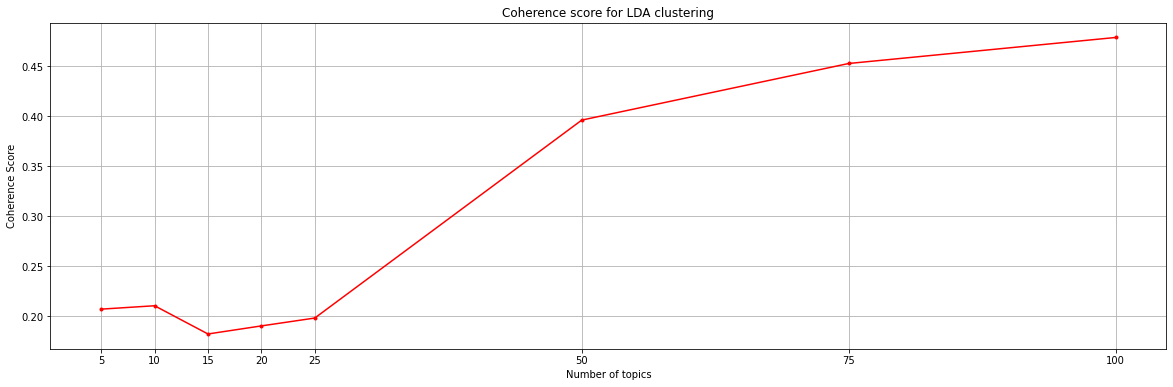

In [193]:
# Coherence scores
# Scores are between 0 and 1. Closer to 1 is better.
plt.figure(figsize=(20, 6))
plt.plot(topics_range, model_results['Coherence'], "r.-")
plt.xlabel("Number of topics")
plt.xticks(topics_range)
plt.ylabel("Coherence Score")
plt.title("Coherence score for LDA clustering")
plt.grid()
plt.show()

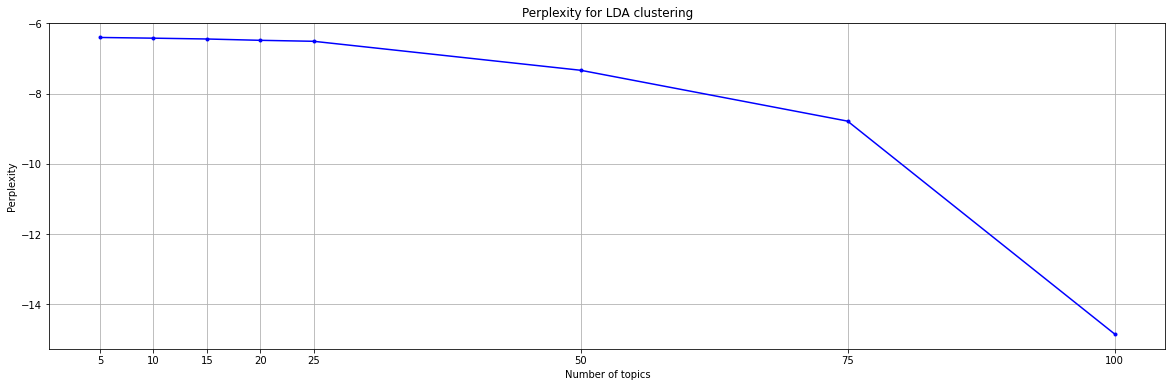

In [194]:
# Log Perplexity
# The higher the figure, the more 'surprising' the new data is,
# A low score suggests a model that adapts better to unseen data.
plt.figure(figsize=(20, 6))
plt.plot(topics_range, model_results['Perplexity'], "b.-")
plt.xlabel("Number of topics")
plt.xticks(topics_range)
plt.ylabel("Perplexity")
plt.title("Perplexity for LDA clustering")
plt.grid()
plt.show()

## Save cluster results to file

In [195]:
# Select the LDA model with optimal number of topics
model_results_df = pd.DataFrame(model_results)
best_index = np.argmax(model_results_df["Coherence"].values)
# best_index = 1
best_num_topics = model_results_df["Topics"].loc[best_index]
best_alpha = model_results_df["Alpha"].loc[best_index]
best_beta = model_results_df["Beta"].loc[best_index]

print("Best index =", best_index)
print(
    f"Optimal number of topics = {best_num_topics}, best alpha = {best_alpha}, best beta = {best_beta}"
)

Best index = 7
Optimal number of topics = 100, best alpha = auto, best beta = auto


In [196]:
best_model = model_list[best_index]
best_model

In [201]:
best_model[lda_corpus[0]]

[(27, 0.66138315), (66, 0.1357626), (72, 0.10181455)]

In [207]:
# Get topic weights
topic_weights = []
# tqdm_bar = tqdm(desc="Extracting topic weights", total=len(best_lda_model[lda_corpus]))
for i, row_list in tqdm(enumerate(best_model[lda_corpus])):
    topic_weights.append([w for i, w in row_list])
#     tqdm_bar.update(1)
# tqdm_bar.close()

361584it [01:31, 3963.89it/s]


In [ ]:
lda_corpus

In [208]:
topic_weights.shape, max(topic_weights), min(topic_weights), topic_weights[:10]

(361584,
 [0.84059334],
 [0.028847612, 0.41684598, 0.340658],
 [[0.6613599, 0.13577776, 0.10182274],
  [0.116726555,
   0.11576484,
   0.11829269,
   0.12095508,
   0.15184213,
   0.119599484,
   0.1250313],
  [0.26081628, 0.20600034, 0.1979413, 0.15660177],
  [0.11268538, 0.20477311, 0.13935693, 0.24524114, 0.17887184],
  [0.32579017, 0.24520978, 0.2738937],
  [0.16684517, 0.6514812],
  [0.15627414, 0.15679029, 0.1566277, 0.15743582, 0.1980066],
  [0.1847015, 0.17492472, 0.19542338, 0.23460157],
  [0.36828652, 0.18548071, 0.23469259],
  [0.13619918, 0.21329555, 0.4946548]])

In [209]:
# Array of topic weights
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
# arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc (skill)
topic_num = np.argmax(arr, axis=1)

In [238]:
type(arr), arr.shape, np.min(arr), np.max(arr), arr[0, :]

(numpy.ndarray,
 (361584, 11),
 0.0,
 0.8405933380126953,
 array([0.66135991, 0.13577776, 0.10182274, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]))

In [232]:
len(topic_num), max(topic_num), min(topic_num), topic_num[:10], len(
    np.unique(topic_num)
), np.unique(topic_num)

(361584,
 8,
 0,
 array([0, 4, 0, 3, 0, 1, 4, 3, 0, 2], dtype=int64),
 9,
 array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64))

In [251]:
# Reduce dimensionality of topic weights using PCA and t-SNE algorithm
pca_datapoint, _, _ = compute_cluster_visualization(
    arr, pca=True, tsne=False, mds=False, seed=SEED
)

Start PCA 2021-05-04 02:22:52.537109
End PCA 2021-05-04 02:22:53.437476
PCA duration 0:00:00.900367


In [253]:
_, _, tsne_datapoint = compute_cluster_visualization(
    arr, pca=False, tsne=True, mds=False, seed=SEED
)

Start t-SNE 2021-05-04 02:24:16.713188
End t-SNE 2021-05-04 03:23:33.303856
t-SNE duration 0:59:16.590668


In [255]:
## Save PCA and t-SNE dimensionality reduced data to file
np.save(OUTPUT_DIR + "skills_lda_pca_datapoints", pca_datapoint)
np.save(OUTPUT_DIR + "skills_lda_tsne_datapoints", tsne_datapoint)

In [ ]:
# # Create text and token columns
# skill_docs["feature_skills_tokens"] = (
#     skill_docs["skill_description_tokens"] + skill_docs["skill_requirement_tokens"]
# )

# skill_docs["feature_skills"] = (
#     skill_docs["job_description"] + skill_docs["job_requirement"]
# )

In [ ]:
# df_clusters = skill_docs[["skill_id", "job_id", "feature_skills", "feature_skills_tokens"]]
# df_clusters["model_type"] = "kmeans"
# df_clusters["number_clusters"] = best_n
# df_clusters["skill_cluster"] = best_labels

In [ ]:
# df_clusters

In [ ]:
# df_clusters.to_csv(OUTPUT_DIR + "job-skill-clusters_wide_wald.csv", index=False)

## Visualize clusters

In [210]:
pca_datapoint = np.load(OUTPUT_DIR + "visualization/" + "skills_wide_pca_datapoints.npy")
tsne_datapoint = np.load(OUTPUT_DIR + "visualization/" + "skills_wide_tsne_datapoints.npy")

In [ ]:
# best_model_df = pd.read_csv(
#     OUTPUT_DIR + "job-skill-clusters_wide_wald.csv",
#     usecols=["skill_cluster", "number_clusters"],
# )

In [ ]:
# best_n = int(best_model_df.loc[0, ['number_clusters']])
# best_labels = best_model_df['skill_cluster'].values
# best_n, len(best_labels)

Start PCA 2021-05-04 09:48:23.796116
End PCA 2021-05-04 09:48:23.852081
PCA duration 0:00:00.055965

Start t-SNE 2021-05-04 09:48:23.852081
End t-SNE 2021-05-04 09:48:23.902085
t-SNE duration 0:00:00.050004



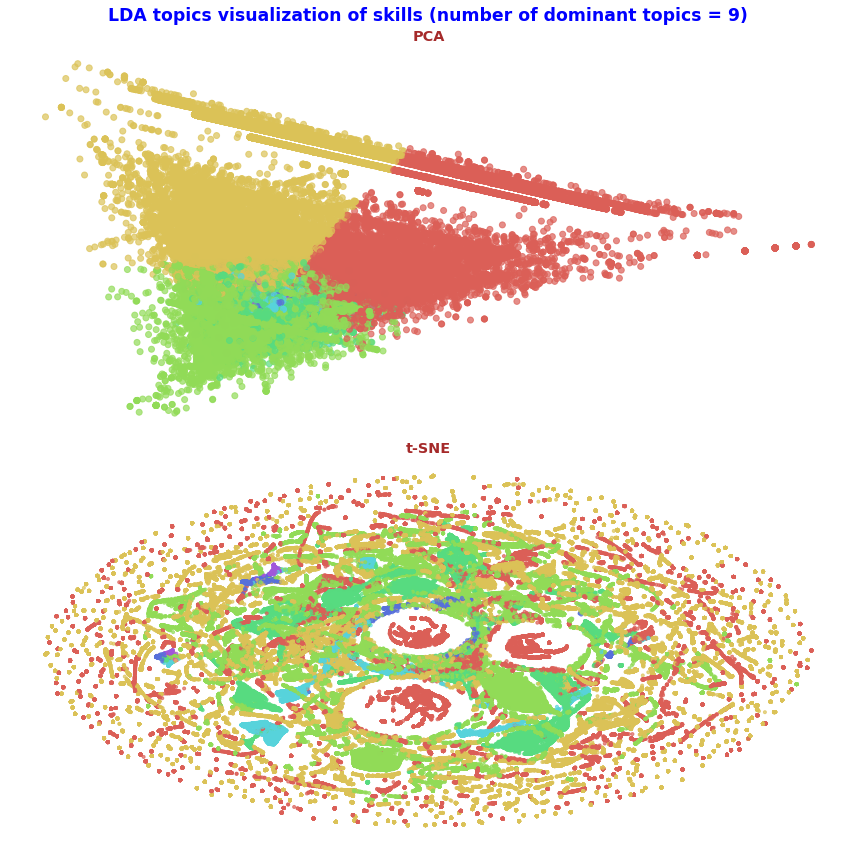

In [256]:
plot_skill = f"LDA topics visualization of skills (number of dominant topics = {len(np.unique(topic_num))})"
palette = sns.color_palette("hls", as_cmap=True)
# colors = cm.nipy_spectral(topic_num / best_num_topics)
colors = topic_num / len(np.unique(topic_num))

# Visualize clusters with PCA and t-SNE
visualize_cluster(
    plot_skill,
    (12, 12),
    colors,
    palette,
    pca_datapoint,
    tsne_datapoint,
    None,
    pca=True,
    tsne=True,
    mds=False
)

In [243]:
# Finding the dominant topic in each sentence
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in tqdm(enumerate(ldamodel[corpus])):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]),
                    ignore_index=True,
                )
            else:
                break
    sent_topics_df.columns = ["Dominant_Topic", "Perc_Contribution", "Topic_Keywords"]

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df


df_topic_sents_keywords = format_topics_sentences(
    ldamodel=best_model, corpus=lda_corpus, texts=skill_corpus
)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = [
    "Document_No",
    "Dominant_Topic",
    "Topic_Perc_Contrib",
    "Keywords",
    "Text",
]

# Show
df_dominant_topic.head(10)

361584it [1:39:11, 60.75it/s]


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,27.0,0.6614,"organization, accounts, specifications, orders...","[ameria, investment, consulting, company, liqu..."
1,1,66.0,0.1518,"unprovided, development, develop, activities, ...","[provides, highly, responsible, incorporation,..."
2,2,66.0,0.1980,"unprovided, development, develop, activities, ...","[complex, staff, assistance, including, evalua..."
3,3,60.0,0.2452,"professional, chief, regulations, accountant, ...","[chief, financial, officer, internal, financia..."
4,4,27.0,0.3254,"organization, accounts, specifications, orders...","[investment, management, investment, team, lea..."
5,5,66.0,0.6515,"unprovided, development, develop, activities, ...","[financial, management, management, team, part..."
6,6,66.0,0.1980,"unprovided, development, develop, activities, ...","[work, performed, recommending, disciplinary, ..."
7,7,66.0,0.2346,"unprovided, development, develop, activities, ...","[technical, proficiency, giving, performance, ..."
8,8,36.0,0.3683,"financial, operations, statements, risks, thro...","[position, manages, audited, financial, statem..."
9,9,89.0,0.4949,"products, etc, loan, matters, negotiations, ac...","[high, level, annual, budgeting, process]"


Start PCA 2021-05-04 02:21:22.250267
End PCA 2021-05-04 02:21:22.364305
PCA duration 0:00:00.114038

Start t-SNE 2021-05-04 02:21:22.364305
End t-SNE 2021-05-04 02:21:22.917278
t-SNE duration 0:00:00.552973



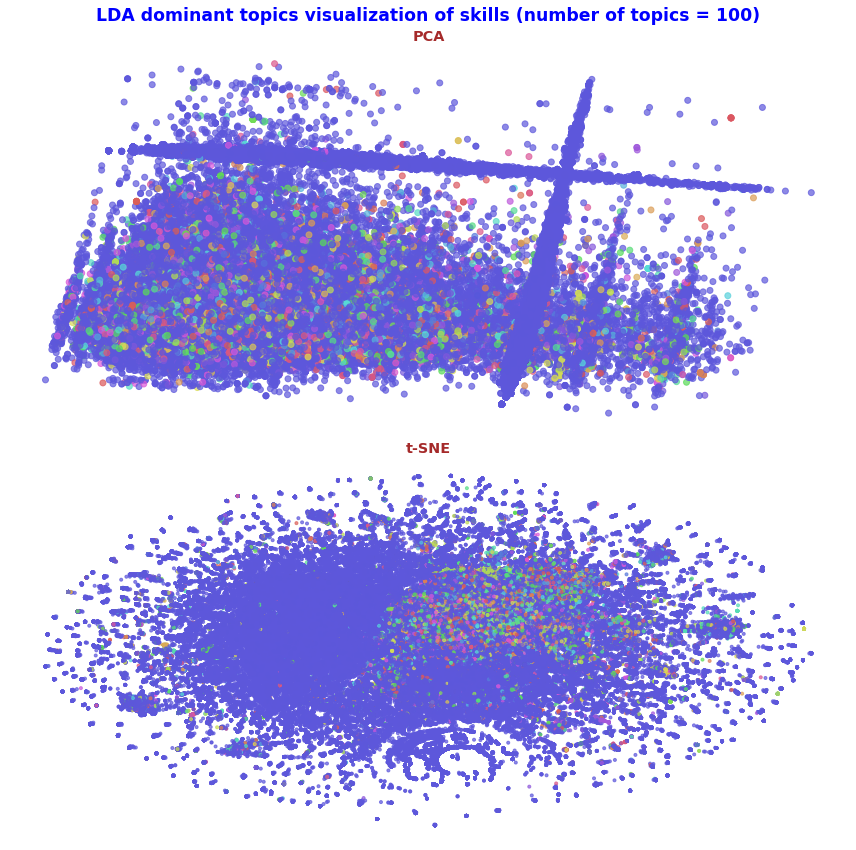

In [250]:
plot_skill = f"LDA dominant topics visualization of skills (number of topics = {best_num_topics})"
palette = sns.color_palette("hls", as_cmap=True)
# colors = cm.nipy_spectral(topic_num / best_num_topics)
colors = df_dominant_topic["Dominant_Topic"].values.tolist() / best_num_topics

# Visualize clusters with PCA and t-SNE
visualize_cluster(
    plot_skill,
    (12, 12),
    colors,
    palette,
    pca_datapoint,
    tsne_datapoint,
    None,
    pca=True,
    tsne=True,
    mds=False
)

In [244]:
# Find the most representative document for each topic

# Group top 5 sentences under each topic
sent_topics_sorted_df = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby("Dominant_Topic")

for i, grp in tqdm(sent_topics_outdf_grpd):
    sent_topics_sorted_df = pd.concat(
        [
            sent_topics_sorted_df,
            grp.sort_values(["Perc_Contribution"], ascending=[0]).head(1),
        ],
        axis=0,
    )

# Reset Index
sent_topics_sorted_df.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorted_df.columns = [
    "Topic_Num",
    "Topic_Perc_Contrib",
    "Keywords",
    "Text",
]

# Show
sent_topics_sorted_df.head(20)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 326.77it/s]


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.6238,"duties, external, promote, related, requested,...","[excellent, training, prepares, analysts, bett..."
1,1.0,0.7418,"monitoring, preparation, submit, cases, automa...","[eu, eastern, partnership, ibm, flagship, eu, ..."
2,2.0,0.6247,"lead, main, deliver, directly, course, rights,...","[rights, project, aiming, undp, human, rights,..."
3,3.0,0.6640,"meetings, functional, tests, letters, levels, ...","[automated, tests, like, functional, develop, ..."
4,4.0,0.7832,"test, existing, framework, safety, scripts, pl...","[mentor, graphics, development, services, cjsc..."
5,5.0,0.6972,"documentation, programs, fulfill, advice, mate...","[provide, legal, advice, provide, legal, advice]"
6,6.0,0.6057,"daily, monthly, operational, seeks, payroll, p...","[stock, clothing, racks, perform, daily, house..."
7,7.0,0.7630,"issues, teams, field, store, value, institutio...","[penitentiary, healthcare, related, issues, pe..."
8,8.0,0.7735,"works, state, visits, recommendations, help, c...","[dr, tb, treatment, management, replace, expat..."
9,9.0,0.7855,"identify, job, officer, opportunities, develop...","[newly, built, elite, house, newly, built, eli..."


In [245]:
# Topic distribution across documents

# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords["Dominant_Topic"].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts / topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[["Dominant_Topic", "Topic_Keywords"]]

# Concatenate Column wise
df_dominant_topics = pd.concat(
    [topic_num_keywords, topic_counts, topic_contribution], axis=1
)

# Change Column names
df_dominant_topics.columns = [
    "Dominant_Topic",
    "Topic_Keywords",
    "Num_Documents",
    "Perc_Documents",
]

df_dominant_topics.dropna(subset=['Num_Documents'], inplace=True)
df_dominant_topics.sort_values(by=['Num_Documents'], ascending=False, inplace=True)

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
66.0,66.0,"unprovided, development, develop, activities, ...",313866.0,0.8680
93.0,66.0,"unprovided, development, develop, activities, ...",1369.0,0.0038
32.0,66.0,"unprovided, development, develop, activities, ...",1291.0,0.0036
40.0,52.0,"make, public, level, written, pr, translations...",1167.0,0.0032
50.0,74.0,"staff, armenia, experience, world, vision, ass...",1100.0,0.0030
...,...,...,...,...
25.0,66.0,"unprovided, development, develop, activities, ...",169.0,0.0005
58.0,74.0,"staff, armenia, experience, world, vision, ass...",167.0,0.0005
33.0,66.0,"unprovided, development, develop, activities, ...",162.0,0.0004
47.0,66.0,"unprovided, development, develop, activities, ...",105.0,0.0003


## Save topic modelling results to file

In [246]:
df_dominant_topic.to_csv(OUTPUT_DIR + "job-skills_dominant-topic_lda.csv", index=False)

In [247]:
sent_topics_sorted_df.to_csv(
    OUTPUT_DIR + "job-skills_represent-doc-per-topic_lda.csv", index=False
)

In [248]:
df_dominant_topics.to_csv(
    OUTPUT_DIR + "job-skills_topic-distribution_lda.csv", index=False
)